# Richards model prediction of Covid-19 for Cuba

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import pymc3 as pm
import arviz as az

## Load data

In [2]:
# Global parameters
country = 'Cuba'
ndays_limit = 31
epidemic_start = 10
x_data_label = 'days_since_{}'.format(epidemic_start)

# loading data
oper_file_path1 = 'data/cuba_data.csv'
df_input = pd.read_csv(oper_file_path1, sep=',', decimal='.', error_bad_lines=False, parse_dates=['date'])
df_input.index = df_input['date']

# Prepare data for model training
df = df_input[df_input['confirmed'] > epidemic_start][['date', 'confirmed', 'new_cases']].copy()
df.columns = ['date', 'acumulado', 'new_cases']
df[x_data_label] = list(np.arange(df.shape[0]))
print(df.tail(10))

                 date  acumulado  new_cases  days_since_10
date                                                      
2020-04-14 2020-04-14        814         48             27
2020-04-15 2020-04-15        862         48             28
2020-04-16 2020-04-16        923         61             29
2020-04-17 2020-04-17        986         63             30
2020-04-18 2020-04-18       1035         49             31
2020-04-19 2020-04-19       1087         52             32
2020-04-20 2020-04-20       1137         50             33
2020-04-21 2020-04-21       1189         52             34
2020-04-22 2020-04-22       1235         46             35
2020-04-23 2020-04-23       1285         50             36


## Model fit

In [5]:
x_values = df[x_data_label].values[:ndays_limit]
y_values = df.acumulado.astype('float64').values[:ndays_limit]
dt_until = str(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]).replace('-', '')
with pm.Model() as richards_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)
    K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
    rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
    a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
    x0 = pm.Uniform('x0', 1, 200, testval=15)
    T = pm.Uniform('T', 1, 3, testval=1.2)
    R0 = pm.Deterministic('R0', np.exp(rate * T))

    # Create likelihood for data
    x = pm.Data("x_data", x_values)
    acumulado = pm.Data("y_data", y_values)
    mu = K * (1 + np.exp(-rate * a * (x - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
    y = pm.Normal('y', mu=mu, tau=sigma, observed=acumulado)
    
with richards_model:
    
    # Sample posterior
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(4000, tune=4000, cores=7, start=start, target_accept=.95, random_seed=1234)

logp = -138.05, ||grad|| = 31.83: 100%|██████████| 68/68 [00:00<00:00, 2993.51it/s]    
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [T, x0, a, rate, K, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 56000/56000 [04:05<00:00, 228.36draws/s]


## Model summary

In [12]:
az.summary(az.from_pymc3(trace))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
rate,0.303,0.046,0.219,0.389,0.000,0.000,8578.0,8578.0,8497.0,10121.0,1.0
sigma[0],0.008,0.002,0.005,0.013,0.000,0.000,14243.0,14243.0,13683.0,13049.0,1.0
K,2039.400,208.921,1647.418,2430.167,2.488,1.759,7053.0,7053.0,7032.0,8773.0,1.0
a,0.285,0.079,0.165,0.429,0.001,0.001,6897.0,6489.0,7403.0,9054.0,1.0
x0,27.409,1.280,25.036,29.807,0.015,0.010,7585.0,7585.0,7588.0,10024.0,1.0
T,1.996,0.576,1.046,2.920,0.004,0.003,16921.0,16775.0,15973.0,12539.0,1.0
R0,1.867,0.380,1.294,2.558,0.003,0.002,14204.0,14204.0,13637.0,12738.0,1.0


In [19]:
pm.backends.tracetab.trace_to_dataframe(trace)

,rate,sigma__0,K,a,x0,T,R0
0,0.363353,0.007282,2262.666325,0.201460,28.606931,2.774227,2.740179
1,0.338248,0.010415,2130.488493,0.227415,27.847816,1.409140,1.610651
2,0.337511,0.008449,2135.663294,0.226333,27.894856,1.179375,1.488921
3,0.297432,0.009503,1909.403299,0.291076,26.499976,2.356581,2.015612
4,0.295008,0.011288,2205.896418,0.261859,28.623319,2.256159,1.945630
...,...,...,...,...,...,...,...
27995,0.229677,0.011635,1831.916454,0.414656,26.546767,2.030374,1.594134
27996,0.282759,0.004988,1709.407600,0.335205,25.004884,1.680102,1.608117
27997,0.213015,0.010185,1782.111116,0.469677,26.271141,2.212335,1.602014
27998,0.222854,0.008984,1636.274444,0.483552,25.026445,2.546719,1.763934


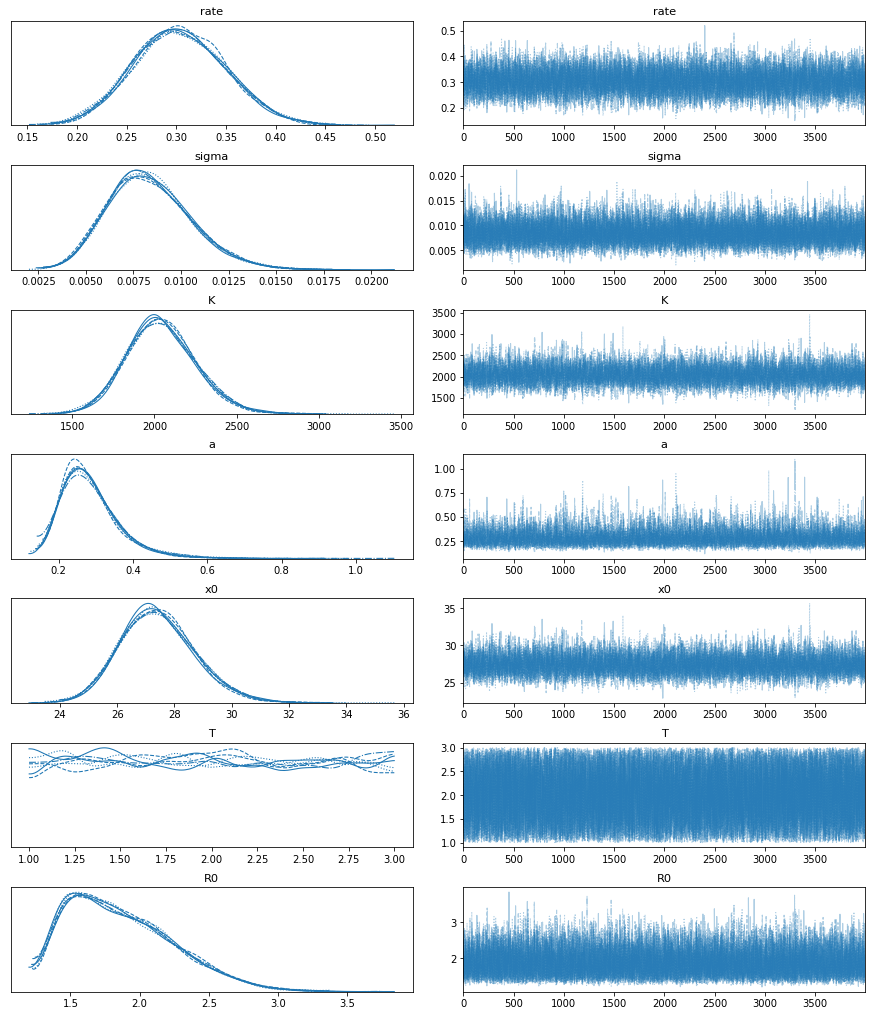

In [13]:
az.plot_trace(trace, compact=True);

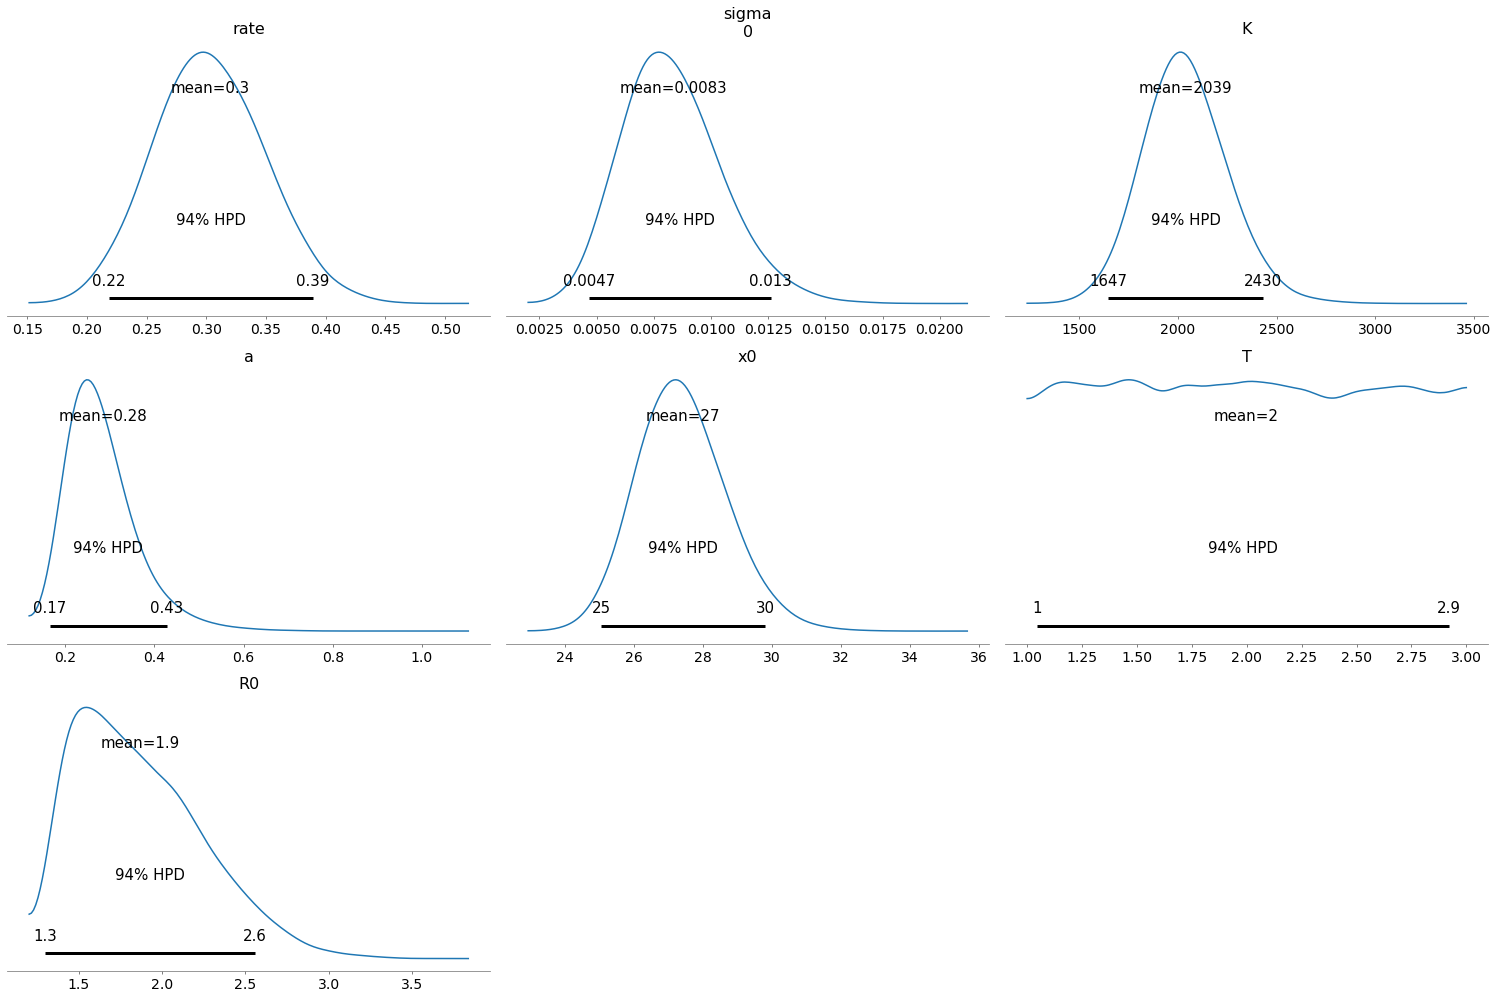

In [14]:
az.plot_posterior(trace);

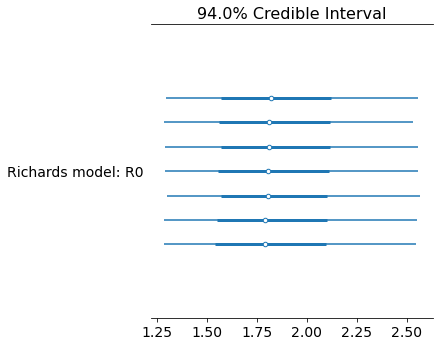

In [32]:
az.plot_forest([trace], model_names=["Richards model"], var_names=['R0']);

In [53]:
# Fitted parameters
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
txt = """
        --------------------------------------
        Fitted parameters for {}:
        --------------------------------------
        Growth rate: {}
        Turning point: {}
        Final size of epidemic: {}
        Basic reproduction number (R0): {}
        --------------------------------------
     """.format(country, *f_values)
print(txt)


        --------------------------------------
        Fitted parameters for Cuba:
        --------------------------------------
        Growth rate: 0.3
        Turning point: 27.41
        Final size of epidemic: 2039.4
        Basic reproduction number (R0): 1.87
        --------------------------------------
     


## Model predictions

In [20]:
# ========== Compute predictions =============
tp = int(round(np.percentile(trace['x0'], 50, axis=0)))
h = tp # 27  # number points to prediction ahead
with richards_model:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, len(y_values) + h)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({"x_data": x_data})
    pm.set_data({"y_data": y_data})

    # Sample posterior predictive
    post_pred_final = pm.sample_posterior_predictive(trace, samples=100)

# Prediction of cumulative cases 
y_min_final = np.percentile(post_pred_final['y'], 2.5, axis=0)
y_max_final = np.percentile(post_pred_final['y'], 97.5, axis=0)
y_fit_final = np.percentile(post_pred_final['y'], 50, axis=0)

# Prediction of incidence of new cases
dy_fit_final = np.percentile(trace['rate'], 50, axis=0) * y_fit_final * (1 - (y_fit_final / np.percentile(trace['K'], 50, axis=0)) ** np.percentile(trace['a'], 50, axis=0))

/home/jrd/.local/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 123.09it/s]


### Plot prediction of comulative cases

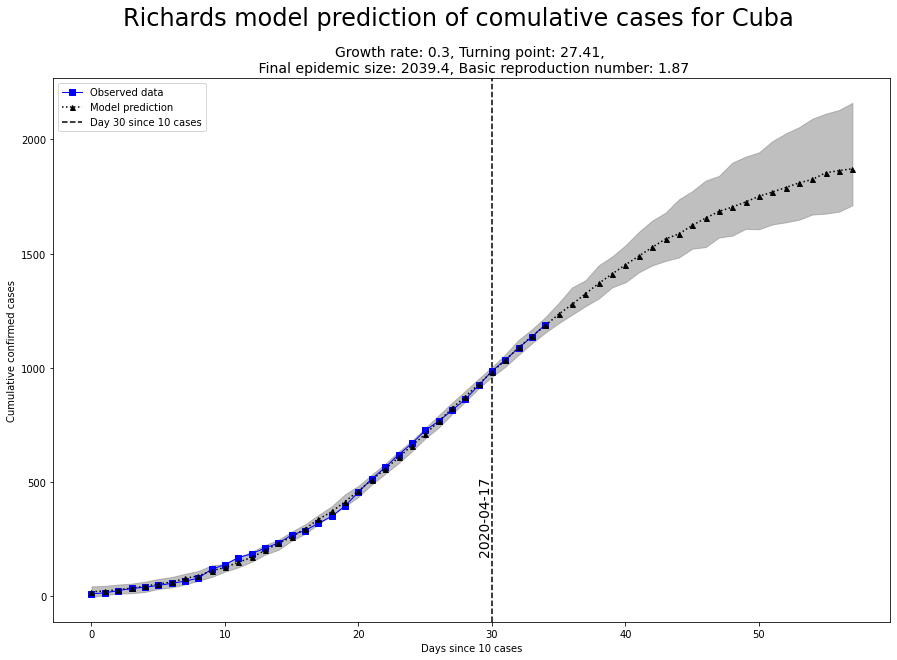

In [27]:
# Plot prediction of comulative cases
#ymax_limit = max(max(y_fit_final), df.acumulado.astype('float64').max()) * 1.10
yref_ycoord_0 = min(np.median(y_fit_final), df.acumulado.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label].values, df.acumulado.astype('float64').values,
         'b', marker='s', ls='-', lw=1, label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), y_fit_final,
         'k', marker='^', ls=':', ms=5, mew=1, label='Model prediction')
plt.fill_between(np.arange(0, post_pred_final['y'].shape[1]), y_min_final, y_max_final, color='0.5', alpha=0.5)
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
plt.suptitle('Richards model prediction of comulative cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
ax.set(xlabel='Days since {} cases'.format(epidemic_start))
ax.set(ylabel='Cumulative confirmed cases')
plt.legend(loc='upper left')
# plt.savefig('results/{}/cumulative_prediction_plot.png'.format(country))
plt.show()

### Plot prediction of incidence of new cases

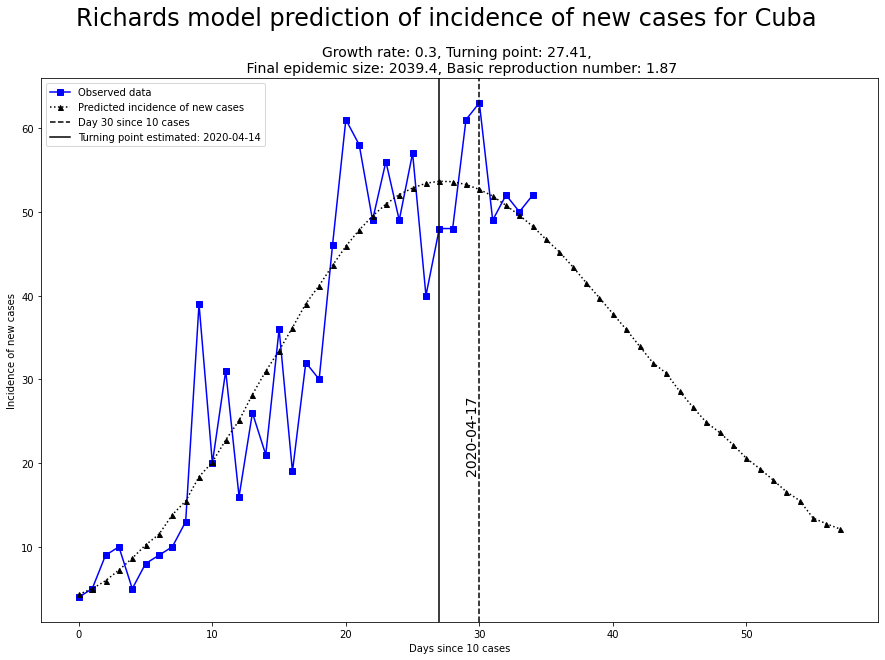

In [29]:
# Incidence of new cases prediction
yref_ycoord_0 = min(np.median(dy_fit_final), df.new_cases.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['new_cases'], 'b', marker='s', ls='-', label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), dy_fit_final, 'k', marker='^', ls=':', ms=5, mew=1,
         label='Predicted incidence of new cases')
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
if tp in list(df[x_data_label].values):
    tp_date = df[df[x_data_label] == tp].date.values[0]
    ax.axvline(tp, ls='-', color='k', label='Turning point estimated: {}'.format(str(tp_date)[:10]))
plt.xlabel('Days since {} cases'.format(epidemic_start))
plt.ylabel('Incidence of new cases')
plt.suptitle('Richards model prediction of incidence of new cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
plt.legend(loc='upper left')
# plt.savefig('results/{}/newcases_prediction_plot.png'.format(country))
plt.show()

## Save the model for further analysis

In [11]:
import pickle 

with open('results/Cuba/model_data.pkl', 'wb') as buff:
    pickle.dump({'model': richards_model, 'trace': trace}, buff)